<a href="https://colab.research.google.com/github/nagaokayuji/learn-ml/blob/main/train_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## check runtime

In [1]:
!nvidia-smi

Sun Apr  3 12:01:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## PyTorch

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
# parameters
learning_rate = 0.001
batch_size = 64
epochs = 5

In [4]:
# load data
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
training_data = datasets.MNIST(
    'data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(
    'data', train=False, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size)

In [6]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [7]:
# definition of the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolution
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        # Fully Connected layer)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x): # overload
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 2D max pooling
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        output = self.fc2(x)
        return output

In [8]:
# instance
model = Net()
model.to(device) # torch device

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
# define loss-function
loss_fn = nn.CrossEntropyLoss()

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### training

In [11]:
for t in range(epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)

        # forward
        output = model(data)
        loss = loss_fn(output, target)
        # back-propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 100 == 0:
            print('epoch: {}, steps: {}/{}, train loss: {:.6f}'.format(
                t + 1,
                batch_idx + 1, len(train_dataloader),
                loss.item()
                ))

    # evaluate with all test data for the epoch
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            correct += (output.argmax(1) == target).type(torch.float).sum().item()
            
    print('epoch: {}, test loss: {:.6f}, test accuracy: {:.6f}'.format(
        t + 1,
        test_loss / len(test_dataloader),
        correct / len(test_dataloader.dataset)
        ))

epoch: 1, steps: 100/938, train loss: 2.191170
epoch: 1, steps: 200/938, train loss: 1.989510
epoch: 1, steps: 300/938, train loss: 1.786096
epoch: 1, steps: 400/938, train loss: 1.372656
epoch: 1, steps: 500/938, train loss: 1.011687
epoch: 1, steps: 600/938, train loss: 0.889908
epoch: 1, steps: 700/938, train loss: 0.697286
epoch: 1, steps: 800/938, train loss: 0.436729
epoch: 1, steps: 900/938, train loss: 0.517984
epoch: 1, test loss: 0.464082, test accuracy: 0.880100
epoch: 2, steps: 100/938, train loss: 0.460823
epoch: 2, steps: 200/938, train loss: 0.435737
epoch: 2, steps: 300/938, train loss: 0.308619
epoch: 2, steps: 400/938, train loss: 0.366603
epoch: 2, steps: 500/938, train loss: 0.396020
epoch: 2, steps: 600/938, train loss: 0.373927
epoch: 2, steps: 700/938, train loss: 0.264895
epoch: 2, steps: 800/938, train loss: 0.359609
epoch: 2, steps: 900/938, train loss: 0.242366
epoch: 2, test loss: 0.330301, test accuracy: 0.907100
epoch: 3, steps: 100/938, train loss: 0.1996

### prediction

In [12]:
import matplotlib.pyplot as plt
def show_img(data):
  plt.imshow(data.reshape((28,28)), cmap='gray_r')

label:  7


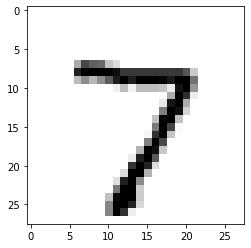

In [13]:
data = test_data[0][0]
print('label: ',test_data[0][1])
show_img(data)

In [14]:
model.eval()
with torch.no_grad():
  x = data.unsqueeze(0).to(device)
  logits = model(x)
  pred = torch.softmax(logits, 1).squeeze().cpu()
pred

tensor([2.0900e-05, 2.4848e-08, 3.3546e-05, 4.1089e-04, 7.6035e-06, 1.4183e-05,
        6.1922e-09, 9.9861e-01, 1.5164e-05, 8.8326e-04])

<BarContainer object of 10 artists>

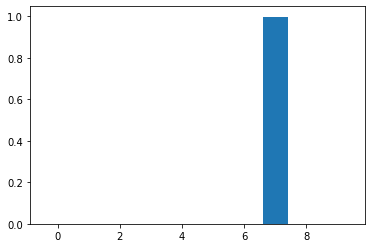

In [15]:
plt.bar(range(10), pred)

In [16]:
pred.argmax()

tensor(7)